# Spam Detection

## Importing Important libraries

In [ ]:
!pip install optuna --q # For tuning hyperparameters

     |████████████████████████████████| 348 kB 4.2 MB/s 
     |████████████████████████████████| 209 kB 39.2 MB/s 
     |████████████████████████████████| 81 kB 7.6 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 50 kB 4.5 MB/s 
     |████████████████████████████████| 147 kB 33.6 MB/s 
     |████████████████████████████████| 112 kB 40.2 MB/s 


In [ ]:
!pip3 install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 4.0 MB/s 


In [ ]:
!pip3 install contractions
import contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 4.2 MB/s 
     |████████████████████████████████| 106 kB 60.7 MB/s 


In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.1 MB/s 


In [ ]:
# Basic modules for reading and manipulating the dataset. 
import pandas as pd
import numpy as np

# For visualisation of the outputs
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# For performing NLP tasks
import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

# Required classifier models 
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# for evaluating the model
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score


# for hyperparameter tuning
import optuna

# to save the required files
import pickle

import warnings
warnings.filterwarnings('ignore') # To prevent kernel from showing any warning

In [ ]:
data=pd.read_csv('completeSpamAssassin.csv')
data.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [ ]:
data.shape

(6046, 3)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


In [ ]:
data.describe()

,Unnamed: 0,Label
count,6046.000000,6046.000000
mean,3022.500000,0.313596
std,1745.474195,0.463993
min,0.000000,0.000000
25%,1511.250000,0.000000
50%,3022.500000,0.000000
75%,4533.750000,1.000000
max,6045.000000,1.000000


In [ ]:
data['Label'].value_counts()

0    4150
1    1896
Name: Label, dtype: int64

In [ ]:
data.isnull().sum()

Unnamed: 0    0
Body          1
Label         0
dtype: int64

In [ ]:
data.duplicated().sum()

0

In [ ]:
data.dropna(inplace=True)

## Observation
### 1. Data contains 6046 rows and 3 columns
### 2. It has 1 string/object column, and one categorical column in int format
### 3. There's only 1 null value present
### 4. There are no duplicate values present within data
### 5. We dropped the one row with the null value 

## Now Lets do some Data Preprocessing
Step 1: Contraction Mapping / Expanding Contractions

Step 2: Tokenization

Step 3: Noise Cleaning - spacing, special characters, lowercasing

Step 4: Spell Checking

Step 5: ‘Stop Words’ Identification

Step 6: Stemming/Lemmatization

Step 7: Tokenization/Vectorization (Countvectororiser/TFID)

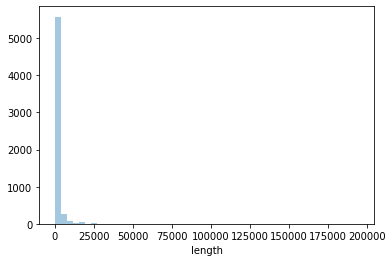

In [ ]:
data["length"] = data["Body"].apply(len)
sns.distplot(data["length"], kde=False);

## Step 1: Contraction Mapping / Expanding Contractions
Contractions are words that we write with an apostrophe. Examples of contractions are words like “ain’t” or “aren’t”. Since we want to standardize our text, it makes sense to expand these contractions. We are going to add a new column to our dataframe called “no_contract” and apply a lambda function to the "msg" field which will expand any contractions

In [ ]:
data['no_contract'] = data['Body'].apply(lambda x: [contractions.fix(word) for word in x.split()])# Creating the new data coloumn called 'no_contract'

In [ ]:
data.head()

,Unnamed: 0,Body,Label,length,no_contract
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www..."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www..."
3,3,##############################################...,1,2863,[#############################################...
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli..."


Also, we would want the expanded contractions to be tokenized separately, therefore we convert the lists under the "no_contract" column back into strings

In [ ]:
data["polish_Body"] = [' '.join(map(str, l)) for l in data['no_contract']]# Creating polish_Body data coloumn and joining it.
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...
3,3,##############################################...,1,2863,[#############################################...,##############################################...
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...


## Step 2: Tokenization
We will begin by breaking apart the corpus into a vocabulary of unique terms, and this is called tokanization.

We can tokenize individual terms and generate what's called a bag of words model. You may notice this model has a glaring pitfall: it fails to capture the innate structure of human language. We can also tokenize using nltk, which is the leading platform for building Python programs to work with human language data

In [ ]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
txt=data['polish_Body'][0]
print(word_tokenize(txt))

['Save', 'up', 'to', '70', '%', 'on', 'Life', 'Insurance', '.', 'Why', 'Spend', 'More', 'Than', 'You', 'Have', 'To', '?', 'Life', 'Quote', 'Savings', 'Ensuring', 'your', 'family', "'s", 'financial', 'security', 'is', 'very', 'important', '.', 'Life', 'Quote', 'Savings', 'makes', 'buying', 'life', 'insurance', 'simple', 'and', 'affordable', '.', 'We', 'Provide', 'FREE', 'Access', 'to', 'The', 'Very', 'Best', 'Companies', 'and', 'The', 'Lowest', 'Rates.Life', 'Quote', 'Savings', 'is', 'FAST', ',', 'EASY', 'and', 'SAVES', 'you', 'money', '!', 'Let', 'us', 'help', 'you', 'get', 'started', 'with', 'the', 'best', 'values', 'in', 'the', 'country', 'on', 'new', 'coverage', '.', 'You', 'can', 'SAVE', 'hundreds', 'or', 'even', 'thousands', 'of', 'dollars', 'by', 'requesting', 'a', 'FREE', 'quote', 'from', 'Lifequote', 'Savings', '.', 'Our', 'service', 'will', 'take', 'you', 'less', 'than', '5', 'minutes', 'to', 'complete', '.', 'Shop', 'and', 'compare', '.', 'SAVE', 'up', 'to', '70', '%', 'on', 

In [ ]:
data['tokenized'] = data['polish_Body'].apply(word_tokenize)
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ..."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ..."
3,3,##############################################...,1,2863,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ..."
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),..."


Step 3: Noise Cleaning - spacing, special characters, lowercasing

### Step 3: Noise Cleaning - spacing, special characters, lowercasing

In [ ]:
# return a random sample of items from an axis of object.
# You can use `random_state` for reproducibility
data.sample(frac=0.05)

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized
5882,5882,CNET Investor Dispatch\nQuote LookupEnter symb...,0,5308,"[CNET, Investor, Dispatch, Quote, LookupEnter,...",CNET Investor Dispatch Quote LookupEnter symbo...,"[CNET, Investor, Dispatch, Quote, LookupEnter,..."
879,879,empty,1,5,[empty],empty,[empty]
5701,5701,empty,0,5,[empty],empty,[empty]
1615,1615,ï¿½ï¿½ï¿½Iï¿½ï¿½ï¿½ï¿½ï¿½zï¿½ï¿½ï¿½{ï¿½iï¿½ï¿½...,1,820,[ï¿½ï¿½ï¿½Iï¿½ï¿½ï¿½ï¿½ï¿½zï¿½ï¿½ï¿½{ï¿½iï¿½ï¿...,ï¿½ï¿½ï¿½Iï¿½ï¿½ï¿½ï¿½ï¿½zï¿½ï¿½ï¿½{ï¿½iï¿½ï¿½...,"[ï¿½ï¿½ï¿½Iï¿½ï¿½ï¿½ï¿½ï¿½zï¿½ï¿½ï¿½, {, ï¿½iï..."
5421,5421,Gojomo:\n>How about a highly error corrected a...,0,801,"[Gojomo:, >How, about, a, highly, error, corre...",Gojomo: >How about a highly error corrected at...,"[Gojomo, :, >, How, about, a, highly, error, c..."
...,...,...,...,...,...,...,...
2050,2050,>I'd normally never buy this but the Xbox is E...,0,604,"[>I would, normally, never, buy, this, but, th...",>I would normally never buy this but the Xbox ...,"[>, I, would, normally, never, buy, this, but,..."
4529,4529,Paul Kelly mentioned:\n> gcc has been as good ...,0,1148,"[Paul, Kelly, mentioned:, >, gcc, has, been, a...",Paul Kelly mentioned: > gcc has been as good a...,"[Paul, Kelly, mentioned, :, >, gcc, has, been,..."
4552,4552,"Hi,On Tue, 30 Jul 2002, Gavin McCullagh wrote:...",0,438,"[Hi,On, Tue,, 30, Jul, 2002,, Gavin, McCullagh...","Hi,On Tue, 30 Jul 2002, Gavin McCullagh wrote:...","[Hi, ,, On, Tue, ,, 30, Jul, 2002, ,, Gavin, M..."
1153,1153,PUBLIC ANNOUNCEMENT:The new domain names are f...,1,1139,"[PUBLIC, ANNOUNCEMENT:The, new, domain, names,...",PUBLIC ANNOUNCEMENT:The new domain names are f...,"[PUBLIC, ANNOUNCEMENT, :, The, new, domain, na..."


Clearly there's a lot going on here: digits, gratuitous whitespace, and all varieties of punctuation. Some terms are randomly capitalized, others are in all-caps. Since these terms might show up in any one of the training examples in countless forms, we need a way to ensure each training example is on equal footing via a preprocessing step called normalization. This form of noise cleaning takes care of spacing and any special characters.

Transforming all words to lowercase is also a very common pre-processing step. In this case, we will once again append a new column named “lower” to the dataframe which will transform all the tokenized words into lowercase. However, because we have to iterate over multiple words we will use a simple for-loop within a lambda function to apply the “lower” function to each word.

In [ ]:
data['lower'] = data['tokenized'].apply(lambda x: [word.lower() for word in x])
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized,lower
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ...","[save, up, to, 70, %, on, life, insurance, ., ..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ..."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ..."
3,3,##############################################...,1,2863,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ..."
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, :, 1, ),..."


Next, we'll remove all punctuation since they serve little value once we begin to analyze our data. Continuing the previous pattern, we will create a new column which has the punctuation removed. We will again utilize a for-loop within a lambda function to iterate over the tokens but this time using an IF condition to only output alpha characters

In [ ]:
punc = string.punctuation
data['no_punc'] = data['lower'].apply(lambda x: [word for word in x if word not in punc])
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized,lower,no_punc
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ...","[save, up, to, 70, %, on, life, insurance, ., ...","[save, up, to, 70, on, life, insurance, why, s..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www...."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www...."
3,3,##############################################...,1,2863,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[adult, club, offers, free, membership, instan..."
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, 1, slim,..."


## Step 4: Spell Checking
For spell checking, we will use Microsoft's TextBlob, which is a simple spelling correction mechanism

In [ ]:
from spellchecker import SpellChecker
spell = SpellChecker()

# data['corrected'] = data['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
# data.head()


### Step 5: Stop Words Identification
Some words in the English language, while necessary, don't contribute much to the meaning of a phrase. These words, such as "when", "had", "those" or "before", are called stop words and should be filtered out.
We are going to add a new column “no_stopwords” which will remove the stopwords from the “no_punc” column since it has been tokenized, had been converted to lowercase and punctuation was removed. Once again a for-loop within a lambda function will iterate over the tokens in “no_punc” and only return the tokens which do not exist in our “stop_words” variable.


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data['stopwords_removed'] = data['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized,lower,no_punc,stopwords_removed,pos_tags
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ...","[save, up, to, 70, %, on, life, insurance, ., ...","[save, up, to, 70, on, life, insurance, why, s...","[save, 70, life, insurance, spend, life, quote...","[(save, VB), (70, CD), (life, NN), (insurance,..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN..."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN..."
3,3,##############################################...,1,2863,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[adult, club, offers, free, membership, instan...","[adult, club, offers, free, membership, instan...","[(adult, NN), (club, NN), (offers, NNS), (free..."
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, 1, slim,...","[thought, might, like, 1, slim, guaranteed, lo...","[(thought, NN), (might, MD), (like, VB), (1, C..."


In [ ]:
nltk.download('averaged_perceptron_tagger')
data['pos_tags'] = data['stopwords_removed'].apply(nltk.tag.pos_tag)
data.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized,lower,no_punc,stopwords_removed,pos_tags
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ...","[save, up, to, 70, %, on, life, insurance, ., ...","[save, up, to, 70, on, life, insurance, why, s...","[save, 70, life, insurance, spend, life, quote...","[(save, VB), (70, CD), (life, NN), (insurance,..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN..."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN..."
3,3,##############################################...,1,2863,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[adult, club, offers, free, membership, instan...","[adult, club, offers, free, membership, instan...","[(adult, NN), (club, NN), (offers, NNS), (free..."
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, 1, slim,...","[thought, might, like, 1, slim, guaranteed, lo...","[(thought, NN), (might, MD), (like, VB), (1, C..."


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
nltk.download('omw-1.4')
nltk.download('wordnet')
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
data['wordnet_pos'] = data['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
data.head()

# Step 6: Stemming/Lemmatization
The idea of stemming is to reduce different forms of word usage into its root word. For example, “drive”, “drove”, “driving”, “driven”, “driver” are derivatives of the word “drive” and very often researchers want to remove this variability from their corpus. Compared to lemmatization, stemming is certainly the less complicated method but it often does not produce a dictionary-specific morphological root of the word. In other words, stemming the word “pies” will often produce a root of “pi” whereas lemmatization will find the morphological root of “pie”.
Instead of taking the easy way out with stemming, let’s apply lemmatization to our data but it requires some additional steps compared to stemming. First, we have to apply parts of speech tags, in other words, determine the part of speech (ie. noun, verb, adverb, etc.) for each word


In [ ]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
data['lemmatized'] = data['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ...","[save, up, to, 70, %, on, life, insurance, ., ...","[save, up, to, 70, on, life, insurance, why, s...","[save, 70, life, insurance, spend, life, quote...","[(save, VB), (70, CD), (life, NN), (insurance,...","[(save, v), (70, n), (life, n), (insurance, n)...","[save, 70, life, insurance, spend, life, quote..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN...","[(1, n), (fight, n), (risk, n), (cancer, n), (...","[1, fight, risk, cancer, http, //www.adclick.w..."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN...","[(1, n), (fight, n), (risk, n), (cancer, n), (...","[1, fight, risk, cancer, http, //www.adclick.w..."
3,3,##############################################...,1,2863,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[adult, club, offers, free, membership, instan...","[adult, club, offers, free, membership, instan...","[(adult, NN), (club, NN), (offers, NNS), (free...","[(adult, n), (club, n), (offers, n), (free, a)...","[adult, club, offer, free, membership, instant..."
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, 1, slim,...","[thought, might, like, 1, slim, guaranteed, lo...","[(thought, NN), (might, MD), (like, VB), (1, C...","[(thought, n), (might, n), (like, v), (1, n), ...","[thought, might, like, 1, slim, guarantee, los..."


In [ ]:
data["length"] = data["lemmatized"].apply(len)
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,98,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ...","[save, up, to, 70, %, on, life, insurance, ., ...","[save, up, to, 70, on, life, insurance, why, s...","[save, 70, life, insurance, spend, life, quote...","[(save, VB), (70, CD), (life, NN), (insurance,...","[(save, v), (70, n), (life, n), (insurance, n)...","[save, 70, life, insurance, spend, life, quote..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,83,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN...","[(1, n), (fight, n), (risk, n), (cancer, n), (...","[1, fight, risk, cancer, http, //www.adclick.w..."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,67,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN...","[(1, n), (fight, n), (risk, n), (cancer, n), (...","[1, fight, risk, cancer, http, //www.adclick.w..."
3,3,##############################################...,1,317,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[adult, club, offers, free, membership, instan...","[adult, club, offers, free, membership, instan...","[(adult, NN), (club, NN), (offers, NNS), (free...","[(adult, n), (club, n), (offers, n), (free, a)...","[adult, club, offer, free, membership, instant..."
4,4,I thought you might like these:\n1) Slim Down ...,1,63,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, 1, slim,...","[thought, might, like, 1, slim, guaranteed, lo...","[(thought, NN), (might, MD), (like, VB), (1, C...","[(thought, n), (might, n), (like, v), (1, n), ...","[thought, might, like, 1, slim, guarantee, los..."


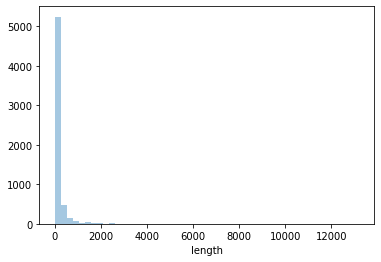

In [ ]:
sns.distplot(data["length"], kde=False);

In [ ]:
data['no_char'] = data['polish_Body'].apply(len)
data['no_words'] = data['polish_Body'].apply(lambda x:len(nltk.word_tokenize(x)))
data['no_sent'] = data['polish_Body'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [ ]:
data.to_csv("Final_dataset.csv")

### This show the partition of the data using pie-plot

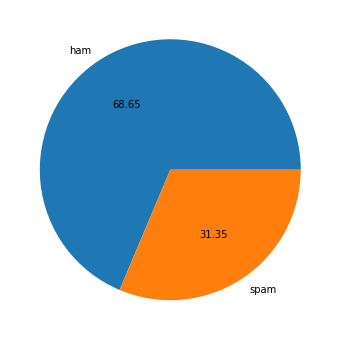

In [ ]:
plt.figure(figsize=(12,6))
plt.pie(data['Label'].value_counts(), labels=['ham','spam'], autopct='%0.2f')
plt.show()

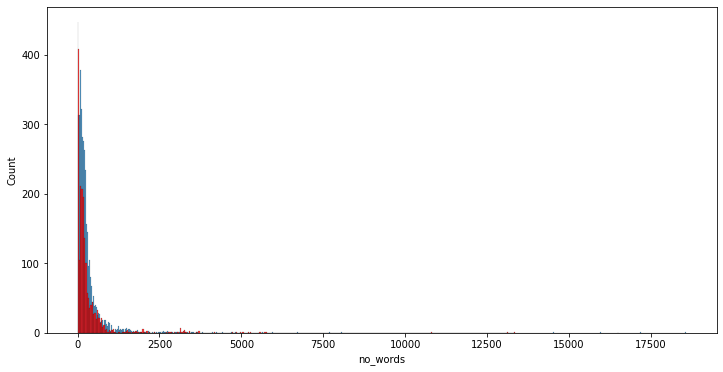

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(data[data['Label'] == 0]['no_words'])
sns.histplot(data[data['Label'] == 1]['no_words'], color='red')
plt.show()

### this is the relation between the labels and the features present in the dataframe

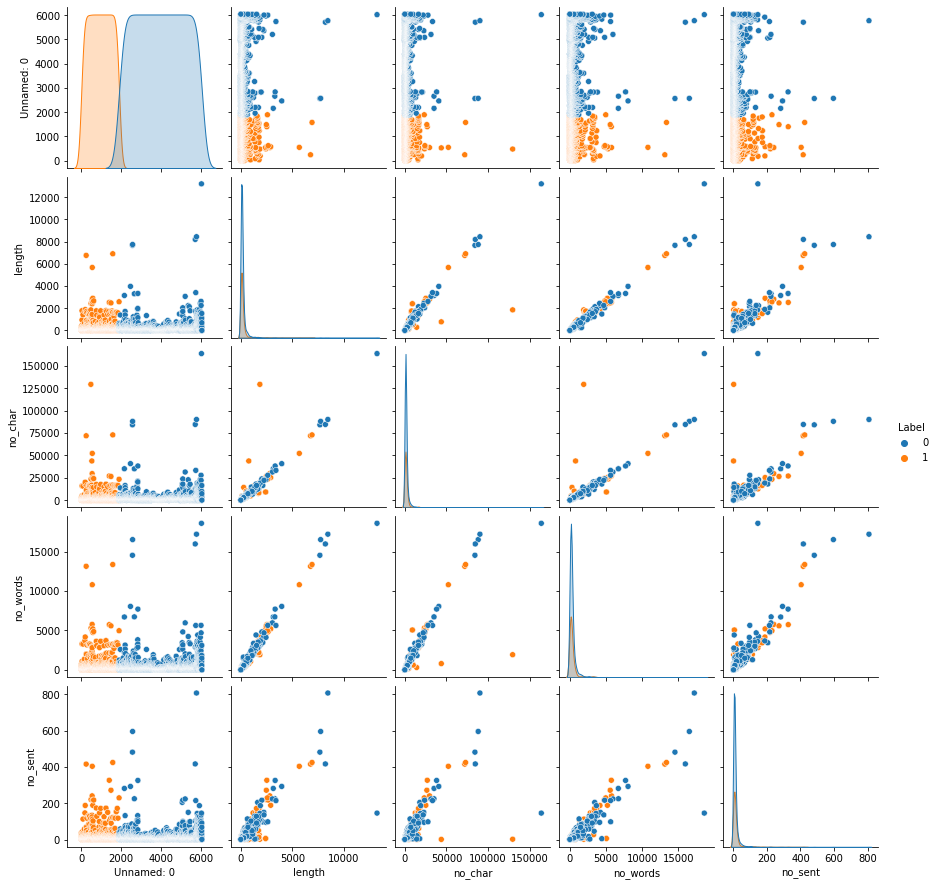

In [ ]:
sns.pairplot(data, hue='Label')
plt.show()

In [ ]:
data['lem_txt'] = data['lemmatized'].apply(lambda x:" ".join(x) )
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized,no_char,no_words,no_sent,lem_txt
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,98,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ...","[save, up, to, 70, %, on, life, insurance, ., ...","[save, up, to, 70, on, life, insurance, why, s...","[save, 70, life, insurance, spend, life, quote...","[(save, VB), (70, CD), (life, NN), (insurance,...","[(save, v), (70, n), (life, n), (insurance, n)...","[save, 70, life, insurance, spend, life, quote...",973,191,12,save 70 life insurance spend life quote saving...
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,83,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN...","[(1, n), (fight, n), (risk, n), (cancer, n), (...","[1, fight, risk, cancer, http, //www.adclick.w...",752,139,5,1 fight risk cancer http //www.adclick.ws/p.cf...
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,67,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN...","[(1, n), (fight, n), (risk, n), (cancer, n), (...","[1, fight, risk, cancer, http, //www.adclick.w...",610,113,4,1 fight risk cancer http //www.adclick.ws/p.cf...
3,3,##############################################...,1,317,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[adult, club, offers, free, membership, instan...","[adult, club, offers, free, membership, instan...","[(adult, NN), (club, NN), (offers, NNS), (free...","[(adult, n), (club, n), (offers, n), (free, a)...","[adult, club, offer, free, membership, instant...",2712,690,35,adult club offer free membership instant acces...
4,4,I thought you might like these:\n1) Slim Down ...,1,63,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, 1, slim,...","[thought, might, like, 1, slim, guaranteed, lo...","[(thought, NN), (might, MD), (like, VB), (1, C...","[(thought, n), (might, n), (like, v), (1, n), ...","[thought, might, like, 1, slim, guarantee, los...",638,108,4,thought might like 1 slim guarantee lose 10-12...


In [ ]:
spam_corpus = []
for mail in data[data['Label'] == 1]['lem_txt'].tolist():
    for word in mail.split():
        spam_corpus.append(word)

# number of words in all spam mails
len(spam_corpus)

ham_corpus = []
for mail in data[data['Label'] == 0]['lem_txt'].tolist():
    for word in mail.split():
        ham_corpus.append(word)

# number of words in all ham mails
len(ham_corpus)

688399

### This shows the bar-plot of top 50 words used in spam msgs

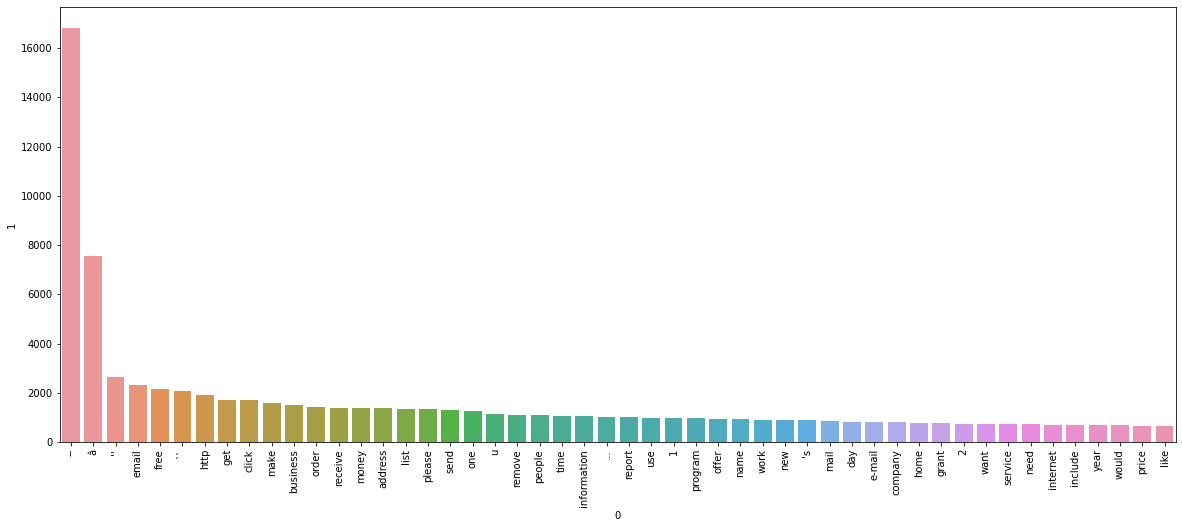

In [ ]:
from collections import Counter
# top 50 most occuring words in the spam mails
plt.figure(figsize=(20,8))
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(50))[0],pd.DataFrame(Counter(spam_corpus).most_common(50))[1])
plt.xticks(rotation='vertical')
plt.show()

### This shows the bar-plot of top 50 words used in ham msgs

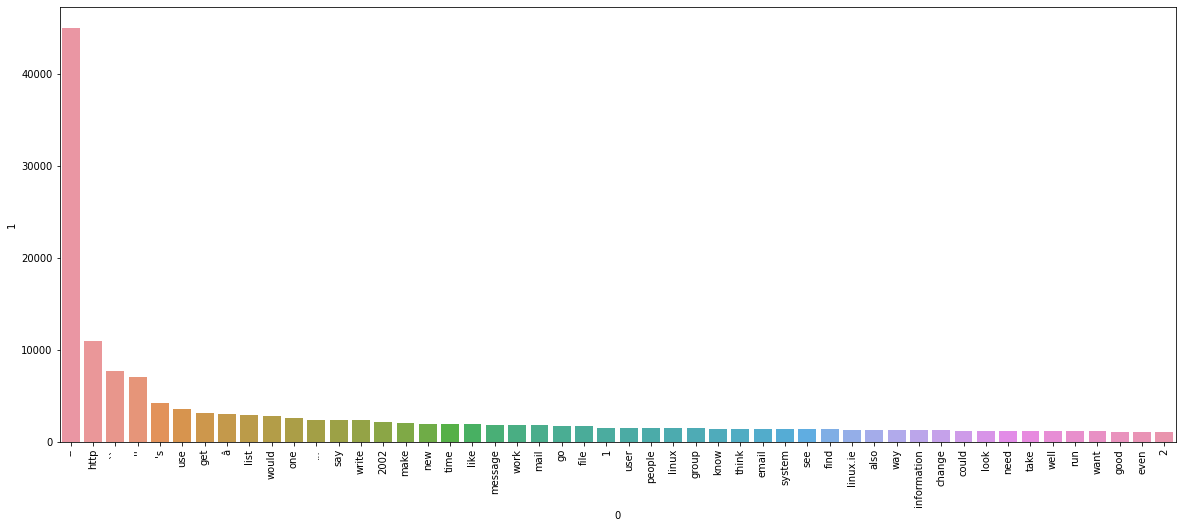

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(50))[0],pd.DataFrame(Counter(ham_corpus).most_common(50))[1])
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
ls=Counter(ham_corpus).most_common(50)
k=[]
for i in ls:
    print(i[0],end=",")
    

--,http,``,'','s,use,get,â,list,would,one,...,say,write,2002,make,new,time,like,message,work,mail,go,file,1,user,people,linux,group,know,think,email,system,see,find,linux.ie,also,way,information,change,could,look,need,take,well,run,want,good,even,2,

# Train Test Split

F-IDF stands for Term Frequency Inverse Document Frequency of records. It can be defined as the calculation of how relevant a word in a series or corpus is to a text. The meaning increases proportionally to the number of times in the text a word appears but is compensated by the word frequency in the corpus (data-set).

Tf-idf is one of the best metrics to determine how significant a term is to a text in a series or a corpus. tf-idf is a weighting system that assigns a weight to each word in a document based on its term frequency (tf) and the reciprocal document frequency (tf) (idf). The words with higher scores of weight are deemed to be more significant.

In [ ]:
#Changing text data in to numbers.

# tfidf = TfidfVectorizer()
tfidf = TfidfVectorizer(max_features=17000)
# Setting up features and target as x and y
x = tfidf.fit_transform(data['lem_txt']).toarray()
y = data['Label'].values

In [ ]:
# Splitting the testing and training datasets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [ ]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=0)
abc = AdaBoostClassifier(n_estimators=50, random_state=0)
bc = BaggingClassifier(n_estimators=50, random_state=0)
etc = ExtraTreesClassifier(n_estimators=50, random_state=0)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=0)
xgb = XGBClassifier(n_estimators=50,random_state=0)
sgd = SGDClassifier(random_state=0)
cat = CatBoostClassifier(verbose=0, random_state=0)
lgbm = LGBMClassifier(random_state=0)

In [ ]:
classifiers = {
    'GaussianNB' : gnb,
    'MultinomialNB' : mnb,
    'BernoulliNB' : bnb,
    'SVC' : svc,
    'KNeighbors' : knc, 
    'DecisionTree': dtc, 
    'LogisticRegression': lrc, 
    'RandomForest': rfc, 
    'AdaBoost': abc, 
    'BaggingClassifier': bc, 
    'ExtraTreesClassifier': etc,
    'GradientBoosting': gbdt,
    'XGB': xgb,
    'SGD' : sgd,
    'Catboost' : cat,
    'LGBM' : lgbm 
}

In [ ]:
#training the classifier
def train_classifier(classifiers,x_train,y_train,x_test,y_test):
    
    classifiers.fit(x_train,y_train)
    
    y_pred = classifiers.predict(x_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [ ]:
# storing accuracy and precision in list
accuracy_scores = []
precision_scores = []

# training all the models on training data
for name,classifier in classifiers.items():
    
    current_accuracy,current_precision = train_classifier(classifier, x_train,y_train,x_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision,'\n')
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  GaussianNB
Accuracy -  0.9214226633581473
Precision -  0.8739946380697051 

For  MultinomialNB
Accuracy -  0.9404466501240695
Precision -  0.8973684210526316 

For  BernoulliNB
Accuracy -  0.9578163771712159
Precision -  0.8948655256723717 

For  SVC
Accuracy -  0.9586435070306039
Precision -  0.9029850746268657 

For  KNeighbors
Accuracy -  0.48883374689826303
Precision -  0.37701612903225806 

For  DecisionTree
Accuracy -  0.8792390405293631
Precision -  0.7676056338028169 

For  LogisticRegression
Accuracy -  0.9330024813895782
Precision -  0.8805194805194805 

For  RandomForest
Accuracy -  0.9429280397022333
Precision -  0.8860759493670886 

For  AdaBoost
Accuracy -  0.9371381306865177
Precision -  0.8651960784313726 

For  BaggingClassifier
Accuracy -  0.9412737799834574
Precision -  0.8778054862842892 

For  ExtraTreesClassifier
Accuracy -  0.9412737799834574
Precision -  0.887468030690537 

For  GradientBoosting
Accuracy -  0.9354838709677419
Precision -  0.887434554973822 

In [ ]:
performance = pd.DataFrame({'Algorithm': classifiers.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance

,Algorithm,Accuracy,Precision
13,SGD,0.960298,0.905473
3,SVC,0.958644,0.902985
14,Catboost,0.955335,0.902010
1,MultinomialNB,0.940447,0.897368
2,BernoulliNB,0.957816,0.894866
15,LGBM,0.950372,0.890547
10,ExtraTreesClassifier,0.941274,0.887468
11,GradientBoosting,0.935484,0.887435
7,RandomForest,0.942928,0.886076
12,XGB,0.931348,0.883905


From the above model we can conclude that SGD performs better than all the other models

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn import tree
x_train,x_test,y_train,y_test = train_test_split(data['lem_txt'],y,test_size=0.2,random_state=0)
nlp_followed_by_dt = Pipeline(
    [
    ("vect", HashingVectorizer(input="content", ngram_range=(1,3))),
    ("tfidf", TfidfTransformer(use_idf=True,)),
    ("dt", SGDClassifier(random_state=0)),
#     ("dt", tree.DecisionTreeClassifier(class_weight="balanced")),
    ]
)
nlp_followed_by_dt.fit(x_train,y_train)

Pipeline(steps=[('vect', HashingVectorizer(ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('dt', SGDClassifier(random_state=0))])

In [ ]:
nlp_followed_by_dt.score(x_test, y_test)

0.9553349875930521

#### So hash vectorization befoe TFID really does some improvement in predicting. 

# Deployment

In [ ]:
import pickle as pkl
filename = 'final_model.pkl'
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)
model=SGDClassifier(random_state=0)
model.fit( x_train,y_train)
pickle.dump(model, open(filename, 'wb'))

 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.9602977667493796